In [ ]:
import os
import django
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'rest.settings')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()

import pandas as pd
import numpy as np
import os
import django
from django.db.models import Max, Min, Avg, Q, F
from asgiref.sync import sync_to_async
import tqdm
from collections import defaultdict
from pandarallel import pandarallel
import requests
import json
from matplotlib import pyplot as plt

import ctypes
from ctypes import c_char_p, cdll
GoInt64 = ctypes.c_int64
GoInt = GoInt64
archive_node = "http://localhost:19545"

from etherscan.utils.parsing import ResponseParser as parser
pandarallel.initialize(progress_bar=True)
# os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'rest.settings')
# os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
# django.setup()

from debtmonitor.models import *
from datavisualization.models import *
from datastorage.models import *
from debtmonitor.help_function import *

import debtmonitor.views as dm
import datavisualization.views as dv
import datastorage.views as ds
import oracleWeb.views as ow

from debtmonitor.debt_function import *

import pickle

tqdm.tqdm.pandas()

pandarallel.initialize(progress_bar=True)

In [ ]:
15342608 - 1000000

In [ ]:
raw_price_data = get_price_data(15342608, previous_block = 1000000)

In [ ]:
price_data = raw_price_data.parallel_apply(reverse_tokens, axis=1)
price_data = pd.concat([price_data, raw_price_data])
price_data

In [ ]:
all_combination = [
    ['uniswapv2', 'usdc', 'eth'],
    ['uniswapv2', 'usdt', 'eth'],
    ['uniswapv2', 'dai', 'eth'],
    ['uniswapv3', 'usdc', 'eth'],
    ['uniswapv3', 'usdt', 'eth'],
    ['uniswapv3', 'dai', 'eth'],
    ['chainlink', 'usdc', 'eth'],
    ['chainlink', 'usdt', 'eth'],
    ['chainlink', 'dai', 'eth'],
]
data_list = []
for combination_i in tqdm.tqdm(all_combination):
    tmp_data = price_data[
        (price_data['oracle_name']==combination_i[0]) &
        (price_data['token0']==combination_i[1]) &
        (price_data['token1']==combination_i[2])
    ].copy()
    tmp_data['_'.join(combination_i)] = tmp_data['current']
    tmp_data = tmp_data[f"block_num {'_'.join(combination_i)}".split(' ')]
    data_list.append(tmp_data)
flat_df = data_list[0]
for df in tqdm.tqdm(data_list[1:]):
    flat_df = flat_df.merge(df, on='block_num', how='outer')
flat_df.set_index('block_num', inplace=True)
flat_df.fillna(method='ffill', inplace=True)
flat_df.fillna(method='bfill', inplace=True)
flat_df.dropna(inplace=True)
flat_df

In [ ]:
flat_df.to_csv('../dataflat_df.csv')

In [70]:

import pandas as pd
import numpy as np
import os

import tqdm
from collections import defaultdict
from pandarallel import pandarallel
import requests
import json
from matplotlib import pyplot as plt

import pickle

tqdm.tqdm.pandas()

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [71]:
flat_df = pd.read_csv('../dataflat_df.csv')

In [72]:
from debtmonitor.help_function import *


def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)] = (df_train[col].iloc[-1] + df_fc[col].cumsum()) # np.exp(df_train[col].iloc[-1] + df_fc[col].cumsum())
    return df_fc

def reverse_tokens(df_row):
    token0 = df_row['token0']
    token1 = df_row['token1']
    current = df_row['current']
    df_row['token0'] = token1
    df_row['token1'] = token0
    df_row['current'] = 1.0/current
    return df_row


# Reference https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    # corr = np.corrcoef(forecast, actual)[0,1]   # corr
    # mins = np.amin(np.hstack([forecast[:,None], 
    #                           actual[:,None]]), axis=1)
    # maxs = np.amax(np.hstack([forecast[:,None], 
    #                           actual[:,None]]), axis=1)
    # minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,})# 'corr':corr, 'minmax':minmax})

def train_n_evaluate(train_data, test_data):
    try:
        train_data_diff = train_data.diff().dropna().reset_index(drop=True)
        model = get_var_result(train_data_diff, maxlags=None)
        lag_order = model.k_ar
        forecast_input = train_data_diff.values[-lag_order:]
        price_diff_prediction = pd.DataFrame(
            model.forecast(y=forecast_input, steps=test_data.shape[0]),
            columns=train_data_diff.columns
        )
        # print(price_diff_prediction.shape)

        price_prediction = invert_transformation(test_data, price_diff_prediction) 
        result_dict = {}
        for i, j in zip(train_data.columns, test_data.columns):
            assert i == j, 'ERROR, name mismatch'
            # print(price_prediction[i].shape, test_data[j].shape)
            result_dict[i] = forecast_accuracy(
                price_prediction[i].values, 
                test_data[j].values
            )

        return json.dumps(result_dict)
    except IndexError:
        return 'IndexError'
    except np.linalg.LinAlgError:
        return 'np.LinAlgError'
    
def main(df, train_block_num, step_ahead):

    main_result_dict = defaultdict(lambda:defaultdict(list))

    train_from_list = []
    train_to_list = []
    test_from_list = []
    test_to_list = []

    split_num = 80
    select_range = df.shape[0] - (step_ahead+train_block_num)
    select_gap = select_range // split_num
    for i in range(split_num):
        train_from_list.append(i*select_gap)
        train_to_list.append(i*select_gap + train_block_num)
        test_from_list.append(i*select_gap + train_block_num)
        test_to_list.append(i*select_gap + train_block_num + step_ahead)


    # split_num = df.shape[0] // (step_ahead+train_block_num)
    # for i in range(split_num):
    #     train_from_list.append(i*(step_ahead+train_block_num))
    #     train_to_list.append(i*(step_ahead+train_block_num)+train_block_num)
    #     test_from_list.append(i*(step_ahead+train_block_num)+train_block_num)
    #     test_to_list.append(i*(step_ahead+train_block_num)+step_ahead+train_block_num)
    # for i in tqdm.tqdm(range(train_block_num, df.shape[0]-step_ahead)):
    #     # train_data = df.iloc[i-train_block_num:i]
    #     # test_data = df.iloc[i:i+step_ahead]
    #     train_data_from = i-train_block_num
    #     train_data_to = i
    #     test_data_from = i
    #     test_data_to = i+step_ahead
    #     train_from_list.append(train_data_from)
    #     train_to_list.append(train_data_to)
    #     test_from_list.append(test_data_from)
    #     test_to_list.append(test_data_to)

    split_df = pd.DataFrame([train_from_list, train_to_list, test_from_list, test_to_list]).T
    split_df.columns = ['train_from', 'train_to', 'test_from', 'test_to']

    def inner_main(split_df_row):
        train_data = df.iloc[split_df_row['train_from']:split_df_row['train_to']]
        test_data = df.iloc[split_df_row['test_from']:split_df_row['test_to']]
        return train_n_evaluate(train_data, test_data)
    
    return split_df.parallel_apply(inner_main, axis=1)

In [ ]:
# train_multiplier = [0.25, 0.5, 1, 2, 3, 4, 5]
# test_multiplier = [0.25, 0.5, 0.75, 1]

In [73]:
train_multiplier = [0.25, 0.5, 1, 2, 3, 4]
# test_multiplier = [0.25, 0.5, 0.75, 1]
test_multiplier = [2,3,4]
for i in tqdm.tqdm(train_multiplier):
    for j in tqdm.tqdm(test_multiplier):
        train_block_num = int(6424 * i)# train
        step_ahead = int(6424*j) # test
        eval_result = main(flat_df, train_block_num, step_ahead)
        with open(f'../data/var_eval_{train_block_num}_{step_ahead}.pickle', 'wb') as handle:
            pickle.dump(eval_result, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [01:37<08:05, 97.02s/it]

 33%|███▎      | 2/6 [05:29<11:47, 176.89s/it]

 50%|█████     | 3/6 [14:24<17:00, 340.27s/it]

 67%|██████▋   | 4/6 [40:40<27:36, 828.19s/it]

 83%|████████▎ | 5/6 [1:28:30<26:04, 1564.49s/it]

100%|██████████| 6/6 [2:45:11<00:00, 1651.89s/it]


100%|██████████| 6/6 [00:00<00:00, 20.08it/s]


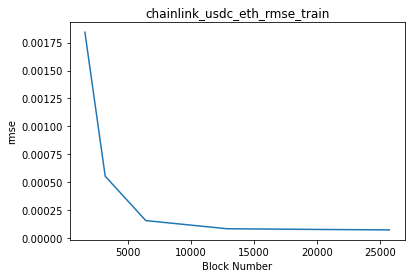

In [85]:
# from inspect import currentframe


# mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
# me = np.mean(forecast - actual)             # ME
# mae = np.mean(np.abs(forecast - actual))    # MAE
# mpe = np.mean((forecast - actual)/actual)   # MPE
# rmse = np.mean((forecast - actual)**2)**.5  # RMSE

metric = 'rmse'
target = 'chainlink_usdc_eth'
gropuby = 'train_multiplier'

train_multiplier = [0.25, 0.5, 1, 2, 3, 4]
test_multiplier = [0.25, 0.5, 0.75, 1, 2, 3, 4]

result_dict = {}
aggregated_accuracy = []
for i in tqdm.tqdm(train_multiplier):
    for j in tqdm.tqdm(test_multiplier):
        train_block_num = int(6424 * i)# train
        step_ahead = int(6424*j) # test
        with open(f'../data/var_eval_{train_block_num}_{step_ahead}.pickle', 'rb') as handle:
            eval_result = pickle.load(handle)
        result_dict[f'{train_block_num}_{step_ahead}'] = eval_result        
        
        dict_list = []
        for k in eval_result.values:
            if k != 'IndexError' and k != 'np.LinAlgError':
                dict_list.append(json.loads(k))
        current_mean = np.mean([q[target][metric] for q in dict_list])
        if current_mean < 100:
            aggregated_accuracy.append([i*6424,j*6424,np.mean([q[target][metric] for q in dict_list])])
aggregated_accuracy = pd.DataFrame(aggregated_accuracy, columns=['train_multiplier', 'test_multiplier', 'accuracy'])



ax = aggregated_accuracy.groupby(gropuby)['accuracy'].mean().plot()
ax.set_xlabel("Block Number")
ax.set_title(f"{target}_{metric}_{gropuby.split('_')[0]}")
ax.set_ylabel(metric)
ax.get_figure().savefig(f"./{target}_{metric}_{gropuby.split('_')[0]}.pdf")

In [67]:
aggregated_accuracy.groupby(gropuby)['accuracy'].mean()

test_multiplier
1606.0    0.158254
3212.0    0.282739
4818.0    0.398997
6424.0    0.420641
Name: accuracy, dtype: float64

In [58]:
aggregated_accuracy

,train_multiplier,test_multiplier,accuracy
0,0.25,0.25,5.535446e-01
1,0.25,0.50,9.491868e-01
2,0.25,0.75,1.511884e+00
3,0.25,1.00,1.652392e+00
4,0.50,0.25,2.317274e-01
5,0.50,0.50,4.669122e-01
6,0.50,0.75,4.582591e-01
7,0.50,1.00,3.724417e+41
8,1.00,0.25,5.843422e-02
9,1.00,0.50,1.104608e-01


In [47]:
eval_result[0]

'{"block_num": {"mape": 0.0017569166923246875, "me": 25393.41641696977, "mae": 25393.41641696977, "mpe": 0.0017569166923246875, "rmse": 25397.711316884455}, "uniswapv2_usdc_eth": {"mape": 0.04418040867997079, "me": -1.4397632190038964e-05, "mae": 1.4397632190038964e-05, "mpe": -0.04418040867997079, "rmse": 1.4964851618726347e-05}, "uniswapv2_usdt_eth": {"mape": 0.04313646646963099, "me": -1.4068284629114696e-05, "mae": 1.4068284629114696e-05, "mpe": -0.04313646646963099, "rmse": 1.463774954750373e-05}, "uniswapv2_dai_eth": {"mape": 0.043888796445637424, "me": -1.3867712712252882e-05, "mae": 1.425592053294889e-05, "mpe": -0.04236557144897607, "rmse": 1.5032027340295827e-05}, "uniswapv3_usdc_eth": {"mape": 0.04473693762794111, "me": -1.4575923661560333e-05, "mae": 1.4575923661560333e-05, "mpe": -0.04473693762794111, "rmse": 1.51282835405038e-05}, "uniswapv3_usdt_eth": {"mape": 0.04611079495454624, "me": -1.5028979663024588e-05, "mae": 1.5028979663024588e-05, "mpe": -0.04611079495454624, 